# Imports and functions

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import pandas as pd
import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

In [ ]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, classification_report

In [ ]:
#Uncomment all lines here, if datasets generation is needed
#from oddt.toolkits.rdk import readfile
#from oddt.toolkits.rdk import Molecule
#from oddt.fingerprints import InteractionFingerprint

In [ ]:
pdb_ids = ['7cb7', '7jkv', '7mhp','7mpb','7rc0','7vh8']

In [ ]:
def N_fixer(path):
    suppl = Chem.SDMolSupplier(path, sanitize=False)
    mol = next(suppl)
    for atom in mol.GetAtoms():
        ncount = atom.GetTotalValence()
        if (atom.GetAtomicNum() == 8)&(ncount == 3):
            for bond in atom.GetBonds():
                if bond.GetBondType()==Chem.rdchem.BondType.DOUBLE:
                    bond.SetBondType(Chem.rdchem.BondType.SINGLE)
                    if (bond.GetEndAtom().GetAtomicNum() == 7)&(bond.GetBeginAtom().GetTotalValence() >= 4):
                        bond.GetEndAtom().SetFormalCharge(1)
                        bond.GetEndAtom().UpdatePropertyCache()
                    elif(bond.GetBeginAtom().GetAtomicNum() == 7)&(bond.GetBeginAtom().GetTotalValence() >= 4):
                        bond.GetBeginAtom().SetFormalCharge(1)
                        bond.GetBeginAtom().UpdatePropertyCache()   
    for atom in mol.GetAtoms():
        ncount = atom.GetTotalValence()
        #print(ncount, atom.GetAtomicNum())
        if (atom.GetAtomicNum() == 7)&(ncount == 4):
            atom.SetFormalCharge(1)
            atom.UpdatePropertyCache()
    with open(path[:-3]+'mol', 'w') as f:
        f.write(Chem.MolToMolBlock(mol, forceV3000=True))
    mol2 = Chem.MolFromMolFile(path[:-3]+'mol', removeHs=False)
    return mol2

In [ ]:
def N_fixer(path):
    suppl = Chem.SDMolSupplier(path, sanitize=False)
    mol = next(suppl)
    for atom in mol.GetAtoms():
        ncount = atom.GetTotalValence()
    #print(ncount, atom.GetAtomicNum())
        if (atom.GetAtomicNum() == 7)&(ncount == 4):
            atom.SetFormalCharge(1)
            atom.UpdatePropertyCache()
    with open(path[:-3]+'mol', 'w') as f:
        f.write(Chem.MolToMolBlock(mol, forceV3000=True))
    mol2 = Chem.MolFromMolFile(path[:-3]+'mol', removeHs=False)
    return mol2

In [ ]:
def N_fixer_mol(mol, path):
    for atom in mol.GetAtoms():
        ncount = atom.GetTotalValence()
    #print(ncount, atom.GetAtomicNum())
        if (atom.GetAtomicNum() == 7)&(ncount == 4):
            atom.SetFormalCharge(1)
            atom.UpdatePropertyCache()
    with open(path, 'w') as f:
        f.write(Chem.MolToMolBlock(mol, forceV3000=True))
    mol2 = Chem.MolFromMolFile(path, removeHs=False)
    return mol2

In [ ]:
def ExplicitBitVect_to_NumpyArray(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))

In [ ]:
def train_test_val_prep(X, y, test_size = 0.3, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = test_size, 
    stratify = y, random_state = random_state)
    X_val, X_test, y_val, y_test = train_test_split(
                X_test, y_test, test_size = 0.5, 
                stratify = y_test, random_state = random_state)
    print('train:val:test - ', '{:.3f}'.format(sum(y_train)/len(y_train)), '{:.3f}'.format(sum(y_val)/len(y_val)), 
          '{:.3f}'.format(sum(y_test)/len(y_test)))
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def GSCV_report(gs_fitted, X_train, X_test, y_train, y_test):
    y_train_predict = gs_fitted.predict_proba(X_train)
    y_test_predict  = gs_fitted.predict_proba(X_test)
    mean_cv_roc     = gs_fitted.best_score_
    train_roc       = roc_auc_score(y_train, y_train_predict[:, 1])
    test_roc        = roc_auc_score(y_test, y_test_predict[:, 1])
    best_params     = gs_fitted.best_params_

    # Print results
    print('*'*10, 'GRID SEARCH RESULTS', '*'*10)
    print('- Mean CV F1:\t{:.3f}'.format(mean_cv_roc))
    print('- Train ROC-AUC:  \t{:.3f}'.format(train_roc))
    print('- Test ROC-AUC:   \t{:.3f}'.format(test_roc))
    print('- Best hyperparameters', best_params)
    print('**'*21)
    print('')

In [ ]:
def gridsearchCV_universal(X_t, X_v, y_t, y_v, estimator, scoring, estimator_hyprms, n_splits):
    skf = StratifiedKFold(n_splits=n_splits)
    cv = skf.split(X_t, y_t)
    # Grid search
    estimator_pipeline = Pipeline([('scaler', MinMaxScaler()), ('estimator', estimator)])
    gs = GridSearchCV(
            estimator    = estimator_pipeline,
            param_grid   = estimator_hyprms,
            cv           = cv,
            scoring      = scoring,
            n_jobs       = 4
    )
    
    # Fit and evaluate the estimator
    gs.fit(X_t, y_t)
    GSCV_report(gs, X_t, X_v, y_t, y_v)
    return gs

In [ ]:
def precision_at_k(y_true, y_score, k, pos_label=1):
    from sklearn.utils import column_or_1d
    from sklearn.utils.multiclass import type_of_target
    
    y_true_type = type_of_target(y_true)
    if not (y_true_type == "binary"):
        raise ValueError("y_true must be a binary column.")
    
    # Makes this compatible with various array types
    y_true_arr = column_or_1d(y_true)
    y_score_arr = column_or_1d(y_score)
    
    y_true_arr = y_true_arr == pos_label
    
    desc_sort_order = np.argsort(y_score_arr)[::-1]
    y_true_sorted = y_true_arr[desc_sort_order]
    y_score_sorted = y_score_arr[desc_sort_order]
    
    true_positives = y_true_sorted[:k].sum()
    
    return true_positives / k

In [ ]:
def recall_at_k(y_true, y_score, k, pos_label=1):
    from sklearn.utils import column_or_1d
    from sklearn.utils.multiclass import type_of_target
    
    y_true_type = type_of_target(y_true)
    if not (y_true_type == "binary"):
        raise ValueError("y_true must be a binary column.")
    
    # Makes this compatible with various array types
    y_true_arr = column_or_1d(y_true)
    y_score_arr = column_or_1d(y_score)
    
    y_true_arr = y_true_arr == pos_label
    
    desc_sort_order = np.argsort(y_score_arr)[::-1]
    y_true_sorted = y_true_arr[desc_sort_order]
    y_score_sorted = y_score_arr[desc_sort_order]
    
    true_positives = y_true_sorted[:k].sum()
    
    return true_positives / y_true.sum()

## Let's split all inactives into 10 groups

В этом разделе мы генерируем батчи молекул, исходя из их разнообразия. В каждый батч отбирается N неактивных молекул  все активные. Не надо выполнять эту часть кода, если недоступен RDKit, и если батчи уже сгенерированы и лежат в файле "batches_ensemble_learning.txt"

In [ ]:
chembl_data = pd.read_csv('/home/anastasia/Documents/Chembl4495582/CHEMBL4495582_v6.csv', delimiter=',',
                          names=['CdId', 'Smiles', 'Mw', 'Formula', 'Chembl_Name', 'Name', 'Max_phase', 
                                 'AlogP', 'Alias', 'Percent'])
df_logP = pd.read_csv('/home/anastasia/Documents/Chembl4495582/Molecules_v6_logP.csv', 
                      names = ['Smiles', 'Chembl_Name', 'logP'])
df_logP = df_logP.drop('Smiles', axis=1)
chembl_data = chembl_data.merge(df_logP, on = 'Chembl_Name')
chembl_data = chembl_data.drop('AlogP', axis=1)
Chembl_heavy_atom_num = pd.read_csv('/home/anastasia/Documents/Chembl4495582/CHEMBL4495582_v6_heavy_atom_count.csv',
                                    names = ['Smiles', 'Chembl_Name', 'Heavy_atom_num'])
Chembl_heavy_atom_num = Chembl_heavy_atom_num.drop('Smiles', axis=1)
chembl_data = chembl_data.merge(Chembl_heavy_atom_num, on = 'Chembl_Name')
chembl_data['Experiment_label'] = [ int(i>60) for i in chembl_data.Percent]
chembl_data = chembl_data.sort_values(by='Percent', ascending=False)
chembl_data['Experiment_rank'] = [i for i in range(1, len(chembl_data)+1)]
chembl_data = chembl_data.sort_values(by='CdId')
chembl_data.head()

,CdId,Smiles,Mw,Formula,Chembl_Name,Name,Max_phase,Alias,Percent,logP,Heavy_atom_num,Experiment_label,Experiment_rank
0,1,C[S+]([O-])c1ccc(cc1)-c1nc(c([nH]1)-c1ccncc1)-...,377.440,C21H16FN3OS,CHEMBL10,SB-203580,0,SB 203580,24.88,3.138292,27,0,966
1,2,CC1(C)Oc2ccc(cc2[C@H]([C@@H]1O)N1CCCC1=O)C#N,286.331,C16H18N2O3,CHEMBL100,LEVCROMAKALIM,0,levcromakalim,20.97,1.022024,21,0,1476
2,3,OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1ccc(=O)[nH]c1=O,244.203,C9H12N2O6,CHEMBL100259,URIDINE,3,Uridine,31.53,-2.415242,17,0,477
3,4,CN=C(S)C1(CCCS1)c1ccccn1,238.370,C11H14N2S2,CHEMBL100424,PICARTAMIDE,0,picartamide,11.46,2.263478,15,0,3739
4,5,N\\C(Sc1ccccc1N)=C(\\C#N)/C(/C#N)=C(/N)Sc1ccccc1N,380.490,C18H16N6S2,CHEMBL100473,U-0126,0,U-0126,-2.56,1.953302,26,0,6548


In [ ]:
ms = []
smiles = [x for x in chembl_data['Smiles'][chembl_data.Experiment_label==0]]
for i in range(len(smiles)):
    x = smiles[i]
    mol2 = Chem.MolFromSmiles(x)
    if mol2:
        ms.append(mol2)
    else:
        mol2 = N_fixer_mol(mol2, '/home/anastasia/Documents/fixed_molecule.mol')
        ms.append(mol2)

In [ ]:
fps = [GetMorganFingerprint(x,3) for x in ms]
fps2 = pd.DataFrame(fps, columns = ['Fingerprint'])
inactive_names=[i for i in chembl_data['Chembl_Name'][chembl_data.Experiment_label==0]]
fps2 = pd.concat([fps2,pd.DataFrame(inactive_names, columns = ['Chembl_Name'])], axis=1)
fps2 = shuffle(fps2, random_state=42)
nfps = len(fps2)
batches = []
for k in tqdm(range(9)):
    fps3 = [i for i in fps2.Fingerprint]
    def distij(i,j,fps=fps3):
        return 1-DataStructs.DiceSimilarity(fps[i],fps[j])
    nfps = len(fps3)
    picker = MaxMinPicker()
    pickIndices = picker.LazyPick(distij,nfps,lms2//10,seed=23)
    #list(pickIndices)
    picks = [x for x in pickIndices]
    #print(picks)
    diverse_mols = list(chembl_data.Chembl_Name.iloc[picks])
    fps2 = fps2.drop(picks)
    fps2=fps2.reset_index(drop=True)
    batches.append(diverse_mols)
batches.append([i for i in fps2.Chembl_Name])

100%|██████████| 9/9 [00:31<00:00,  3.49s/it]


In [ ]:
for i in range(len(batches)):
    print(len(batches[i]))

667
667
667
667
667
667
667
667
667
670


In [ ]:
active_ids = [i for i in chembl_data['Chembl_Name'][chembl_data.Experiment_label==1]]

In [ ]:
summ = 0
for i in range(len(batches)):
    batches[i]+=active_ids
    print(len(batches[i]))
    summ+=len(batches[i])

891
891
891
891
891
891
891
891
891
894


## Let's generate datasets

На основании ранее сгенерированных списков молекул, генерируем разбитые на батчи датасеты

In [ ]:
batches = []
with open('/home/anastasia/Documents/Chembl4495582_Fomina/batches_ensemble_learning.txt') as inf:
    for line in inf:
        batch = line.strip().split(',')
        batches.append(batch)

In [ ]:
Set9 = pd.read_csv('/home/anastasia/Documents/Chembl4495582_Fomina/Chembl4495582_Set9.csv', index_col=0)

In [ ]:
Set9

,Chembl_Name,0,1,2,3,4,5,6,7,8,...,Grid_Score_7cb7,Grid_Score_7mpb,Grid_Score_7mhp,Grid_Score_7vh8,Grid_Score_7rc0,Mw,logP,Percent,Experiment_rank,Experiment_label
0,CHEMBL10,0,0,0,0,0,0,0,0,0,...,-37.316181,-30.805252,-31.948048,-36.003437,-27.870602,377.440,3.138292,24.88,966,0
1,CHEMBL100,0,0,0,1,1,0,0,0,0,...,-34.852295,-31.238728,-27.943371,-35.349831,-33.367020,286.331,1.022024,20.97,1476,0
2,CHEMBL100259,0,0,0,0,0,0,0,0,0,...,-34.560555,-34.023727,-30.177105,-35.462032,-33.423267,244.203,-2.415242,31.53,477,0
3,CHEMBL100424,0,0,0,0,1,0,0,0,0,...,-30.326897,-31.173742,-28.237204,-30.232658,-31.082962,238.370,2.263478,11.46,3739,0
4,CHEMBL100473,0,1,0,0,0,1,0,0,0,...,-36.932201,-42.139709,-41.349922,-39.431709,-38.675064,380.490,1.953302,-2.56,6548,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,CHEMBL995,0,0,0,0,0,0,0,0,0,...,-45.560795,-40.692627,-45.211800,-43.341118,-44.733994,421.910,5.003479,20.87,1487,0
6728,CHEMBL996,0,0,0,0,0,0,1,0,0,...,-41.931141,-46.609779,-43.989006,-48.202469,-47.242767,427.450,0.288359,4.46,5476,0
6729,CHEMBL99668,0,0,0,0,0,0,0,0,0,...,-38.844261,-35.831299,-35.069622,-36.915371,-35.920124,291.267,-1.422364,14.22,2957,0
6730,CHEMBL9967,0,0,0,0,0,0,0,0,0,...,-46.475452,-42.751408,-36.070297,-44.013496,-41.348061,351.410,0.967023,13.10,3277,0


In [ ]:
y = Set9['Experiment_label']
X = Set9.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train_set9, X_val_set9, X_test_set9, y_train_set9, y_val_set9, y_test_set9 = train_test_val_prep(
                                                                        X, y, test_size = 0.3, random_state = 42)
scaler = MinMaxScaler()
scaler.fit(X_train_set9.iloc[:,1:])
columns = list(X_train_set9.iloc[:,1:].columns)
X_train_clean_set9 = pd.concat([X_train_set9.reset_index(drop=True)['Chembl_Name'], 
                                pd.DataFrame(scaler.transform(X_train_set9.iloc[:,1:]),
                                                                columns = columns)], axis=1)
X_val_clean_set9 = pd.concat([X_val_set9.reset_index(drop=True)['Chembl_Name'], 
                              pd.DataFrame(scaler.transform(X_val_set9.iloc[:,1:]),
                                                                columns = columns)], axis=1)
X_test_clean_set9 = pd.concat([X_test_set9.reset_index(drop=True)['Chembl_Name'], 
                               pd.DataFrame(scaler.transform(X_test_set9.iloc[:,1:]),
                                                                columns = columns)], axis=1)
Set9_train = pd.concat([X_train_clean_set9, y_train_set9.reset_index(drop=True)], axis=1)

train:val:test -  0.032 0.032 0.032


In [ ]:
imbalance_train = np.sum(y_train_set9)/len(y_train_set9)
imbalance_val = np.sum(y_val_set9)/len(y_val_set9)
imbalance_test = np.sum(y_test_set9)/len(y_test_set9)

In [ ]:
print(imbalance_train, imbalance_val, imbalance_test)

0.03183361629881155 0.031683168316831684 0.031683168316831684


In [ ]:
Set9_train

,Chembl_Name,0,1,2,3,4,5,6,7,8,...,7vh8_S_B_301_hbonda,Grid_Score_7jkv,Grid_Score_7cb7,Grid_Score_7mpb,Grid_Score_7mhp,Grid_Score_7vh8,Grid_Score_7rc0,Mw,logP,Experiment_label
0,CHEMBL521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.732810,0.741591,0.494932,0.762445,0.604114,0.774020,0.168116,0.526118,0
1,CHEMBL1289926,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.658854,0.643355,0.384015,0.538499,0.510846,0.626496,0.358358,0.536986,0
2,CHEMBL310555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.863623,0.873207,0.598612,0.881981,0.728720,0.890075,0.103580,0.454348,0
3,CHEMBL3286580,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.537409,0.525313,0.402403,0.542840,0.434091,0.582736,0.370930,0.560004,0
4,CHEMBL1213082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.5,0.629468,0.663895,0.408423,0.641739,0.495058,0.652905,0.369943,0.498793,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,CHEMBL2105698,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.639067,0.641721,0.428264,0.585663,0.531963,0.682966,0.374586,0.463703,0
4708,CHEMBL269671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.821310,0.835946,0.546975,0.830387,0.663839,0.864022,0.248412,0.500151,0
4709,CHEMBL1718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.723083,0.699778,0.512132,0.713348,0.565550,0.686727,0.295970,0.442128,0
4710,CHEMBL3342553,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.588604,0.504087,0.389654,0.619775,0.436319,0.567489,0.461890,0.465572,0


In [ ]:
batches_dfs_set9 = []
for i in range(len(batches)):
    df = Set9_train[Set9_train.Chembl_Name.isin(batches[i])]
    print(len(df))
    print('act/inact:',round(sum(df.Experiment_label)/len(df),2))
    batches_dfs_set9.append(df)

588
act/inact: 0.26
603
act/inact: 0.25
608
act/inact: 0.25
593
act/inact: 0.25
589
act/inact: 0.25
603
act/inact: 0.25
593
act/inact: 0.25
599
act/inact: 0.25
598
act/inact: 0.25
630
act/inact: 0.24


In [ ]:
Set8 = pd.read_csv('/home/anastasia/Documents/Chembl4495582_Fomina/Chembl4495582_Set8.csv', index_col=0)
y = Set8['Experiment_label']
X = Set8.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train_set8, X_val_set8, X_test_set8, y_train_set8, y_val_set8, y_test_set8 = train_test_val_prep(
                                                                        X, y, test_size = 0.3, random_state = 42)
scaler = MinMaxScaler()
scaler.fit(X_train_set8.iloc[:,1:])
columns = list(X_train_set8.iloc[:,1:].columns)
X_train_clean_set8 = pd.concat([X_train_set8.reset_index(drop=True)['Chembl_Name'], 
                                pd.DataFrame(scaler.transform(X_train_set8.iloc[:,1:]),
                                                                columns = columns)], axis=1)
X_val_clean_set8 = pd.concat([X_val_set8.reset_index(drop=True)['Chembl_Name'], 
                              pd.DataFrame(scaler.transform(X_val_set8.iloc[:,1:]),
                                                                columns = columns)], axis=1)
X_test_clean_set8 = pd.concat([X_test_set8.reset_index(drop=True)['Chembl_Name'], 
                               pd.DataFrame(scaler.transform(X_test_set8.iloc[:,1:]),
                                                                columns = columns)], axis=1)
Set8_train = pd.concat([X_train_clean_set8, y_train_set8.reset_index(drop=True)], axis=1)
Set8_train

train:val:test -  0.032 0.032 0.032


,Chembl_Name,0,1,2,3,4,5,6,7,8,...,1023,Grid_Score_7jkv,Grid_Score_7cb7,Grid_Score_7mpb,Grid_Score_7mhp,Grid_Score_7vh8,Grid_Score_7rc0,Mw,logP,Experiment_label
0,CHEMBL521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.732810,0.741591,0.494932,0.762445,0.604114,0.774020,0.168116,0.526118,0
1,CHEMBL1289926,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.658854,0.643355,0.384015,0.538499,0.510846,0.626496,0.358358,0.536986,0
2,CHEMBL310555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.863623,0.873207,0.598612,0.881981,0.728720,0.890075,0.103580,0.454348,0
3,CHEMBL3286580,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.537409,0.525313,0.402403,0.542840,0.434091,0.582736,0.370930,0.560004,0
4,CHEMBL1213082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.629468,0.663895,0.408423,0.641739,0.495058,0.652905,0.369943,0.498793,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,CHEMBL2105698,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.639067,0.641721,0.428264,0.585663,0.531963,0.682966,0.374586,0.463703,0
4708,CHEMBL269671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.821310,0.835946,0.546975,0.830387,0.663839,0.864022,0.248412,0.500151,0
4709,CHEMBL1718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.723083,0.699778,0.512132,0.713348,0.565550,0.686727,0.295970,0.442128,0
4710,CHEMBL3342553,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.588604,0.504087,0.389654,0.619775,0.436319,0.567489,0.461890,0.465572,0


In [ ]:
batches_dfs_set8 = []
for i in range(len(batches)):
    df = Set8_train[Set8_train.Chembl_Name.isin(batches[i])]
    print(len(df))
    print('act/inact:',round(sum(df.Experiment_label)/len(df),2))
    batches_dfs_set8.append(df)

588
act/inact: 0.26
603
act/inact: 0.25
608
act/inact: 0.25
593
act/inact: 0.25
589
act/inact: 0.25
603
act/inact: 0.25
593
act/inact: 0.25
599
act/inact: 0.25
598
act/inact: 0.25
630
act/inact: 0.24


In [ ]:
Set7 = pd.read_csv('/home/anastasia/Documents/Chembl4495582_Fomina/Chembl4495582_Set7.csv', index_col=0)
y = Set7['Experiment_label']
X = Set7.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train_set7, X_val_set7, X_test_set7, y_train_set7, y_val_set7, y_test_set7 = train_test_val_prep(
                                                                        X, y, test_size = 0.3, random_state = 42)
scaler = MinMaxScaler()
scaler.fit(X_train_set7.iloc[:,1:])
columns = list(X_train_set7.iloc[:,1:].columns)
X_train_clean_set7 = pd.concat([X_train_set7.reset_index(drop=True)['Chembl_Name'], 
                                pd.DataFrame(scaler.transform(X_train_set7.iloc[:,1:]),
                                                                columns = columns)], axis=1)
X_val_clean_set7 = pd.concat([X_val_set7.reset_index(drop=True)['Chembl_Name'], 
                              pd.DataFrame(scaler.transform(X_val_set7.iloc[:,1:]),
                                                                columns = columns)], axis=1)
X_test_clean_set7 = pd.concat([X_test_set7.reset_index(drop=True)['Chembl_Name'], 
                               pd.DataFrame(scaler.transform(X_test_set7.iloc[:,1:]),
                                                                columns = columns)], axis=1)
Set7_train = pd.concat([X_train_clean_set7, y_train_set7.reset_index(drop=True)], axis=1)
Set7_train

train:val:test -  0.032 0.032 0.032


,Chembl_Name,7cb7_T_A_24_hbondd,7cb7_T_A_24_hbonda,7cb7_T_A_25_hphob,7cb7_T_A_25_hbondd,7cb7_T_A_25_hbonda,7cb7_T_A_26_hbondd,7cb7_T_A_26_hbonda,7cb7_L_A_27_hphob,7cb7_H_A_41_hphob,...,7vh8_S_B_301_hbonda,Grid_Score_7jkv,Grid_Score_7cb7,Grid_Score_7mpb,Grid_Score_7mhp,Grid_Score_7vh8,Grid_Score_7rc0,Mw,logP,Experiment_label
0,CHEMBL521,0.333333,0.333333,0.333333,0.333333,0.5,0.333333,0.333333,0.333333,0.333333,...,0.5,0.732810,0.741591,0.494932,0.762445,0.604114,0.774020,0.168116,0.526118,0
1,CHEMBL1289926,0.333333,0.333333,0.333333,0.333333,0.5,0.333333,0.333333,0.333333,0.333333,...,0.5,0.658854,0.643355,0.384015,0.538499,0.510846,0.626496,0.358358,0.536986,0
2,CHEMBL310555,0.333333,0.333333,0.333333,0.333333,0.5,0.333333,0.333333,0.333333,0.333333,...,0.5,0.863623,0.873207,0.598612,0.881981,0.728720,0.890075,0.103580,0.454348,0
3,CHEMBL3286580,0.333333,0.333333,0.333333,0.333333,0.5,0.333333,0.333333,0.333333,0.333333,...,0.5,0.537409,0.525313,0.402403,0.542840,0.434091,0.582736,0.370930,0.560004,0
4,CHEMBL1213082,0.333333,0.333333,0.333333,0.333333,0.5,0.333333,0.333333,0.333333,0.333333,...,0.5,0.629468,0.663895,0.408423,0.641739,0.495058,0.652905,0.369943,0.498793,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,CHEMBL2105698,0.333333,0.333333,0.333333,0.333333,0.5,0.333333,0.333333,0.333333,0.333333,...,0.5,0.639067,0.641721,0.428264,0.585663,0.531963,0.682966,0.374586,0.463703,0
4708,CHEMBL269671,0.333333,0.333333,0.333333,0.333333,0.5,0.333333,0.333333,0.333333,0.333333,...,0.5,0.821310,0.835946,0.546975,0.830387,0.663839,0.864022,0.248412,0.500151,0
4709,CHEMBL1718,0.333333,0.333333,0.333333,0.333333,0.5,0.333333,0.333333,0.333333,0.333333,...,0.5,0.723083,0.699778,0.512132,0.713348,0.565550,0.686727,0.295970,0.442128,0
4710,CHEMBL3342553,0.333333,0.333333,0.333333,0.333333,0.5,0.333333,0.333333,0.333333,0.333333,...,0.5,0.588604,0.504087,0.389654,0.619775,0.436319,0.567489,0.461890,0.465572,0


In [ ]:
batches_dfs_set7 = []
for i in range(len(batches)):
    df = Set7_train[Set7_train.Chembl_Name.isin(batches[i])]
    print(len(df))
    print('act/inact:',round(sum(df.Experiment_label)/len(df),2))
    batches_dfs_set7.append(df)

588
act/inact: 0.26
603
act/inact: 0.25
608
act/inact: 0.25
593
act/inact: 0.25
589
act/inact: 0.25
603
act/inact: 0.25
593
act/inact: 0.25
599
act/inact: 0.25
598
act/inact: 0.25
630
act/inact: 0.24


## Let's make ensembles from some previosly selected models

Основная часть - обучение моделей. Оптимизация моделей не проводилась - параметры подобраны ранее в ноутбуке Chembl4495582_main.ipynb

In [ ]:
def majority_vote(models_list, X):
    ### Функция принимает на вход список с обученными на батчах моделями и любой соответствующий датасет Х, 
    ### для которого нужно сделать прогноз.
    ### Функция возвращает средние по всем моделям спрогнозированные вероятности принадлежности классу активных 
    ### для объектов датасета Х
    preds = []
    for i in range(len(models_list)):
        y_pred = model.predict_proba(X)[:, 1]
        preds.append(y_pred)
    preds = np.array(preds)
    preds = preds.T
    preds = preds.tolist()
    vote = [np.mean(i) for i in preds]
    return np.array(vote)

In [ ]:
def max_vote(models_list, X):
    ### Функция принимает на вход список с обученными на батчах моделями и любой соответствующий датасет Х, 
    ### для которого нужно сделать прогноз.
    ### Функция возвращает максимальные по всем моделям спрогнозированные вероятности принадлежности классу активных 
    ### для объектов датасета Х
    preds = []
    for i in range(len(models_list)):
        y_pred = model.predict_proba(X)[:, 1]
        preds.append(y_pred)
    preds = np.array(preds)
    preds = preds.T
    #print(preds)
    preds = preds.tolist()
    vote = [np.max(i) for i in preds]
    return np.array(vote)

### Set9

In [ ]:
models_set9 = [LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.0001, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0,C=1, random_state = 42),
           ]

In [ ]:
lr_models_batches_set9 = []
for i in range(len(batches_dfs_set9)):
    dataset = batches_dfs_set9[i]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Chembl_Name'], axis = 1)
    model = models_set9[0]
    model.fit(X,y)
    y_pred = model.predict_proba(X)
    print('batch ', i, ' ROCAUC:\t', roc_auc_score(y,y_pred[:, 1]))
    lr_models_batches_set9.append(model)
y_pred_lr_train_proba_set9 = majority_vote(lr_models_batches_set9, 
                                          X_train_clean_set9.drop(['Chembl_Name'], axis = 1))
y_pred_lr_train_set9 = [int(i>=0.5) for i in y_pred_lr_train_proba_set9]
y_pred_lr_test_proba_set9 = majority_vote(lr_models_batches_set9, 
                                          X_test_clean_set9.drop(['Chembl_Name'], axis = 1))
y_pred_lr_test_set9 = [int(i>=0.5) for i in y_pred_lr_test_proba_set9]
y_pred_lr_train_max_proba_set9 = max_vote(lr_models_batches_set9, X_train_clean_set9.drop(['Chembl_Name'], axis = 1))
y_pred_lr_test_max_proba_set9 = max_vote(lr_models_batches_set9, X_test_clean_set9.drop(['Chembl_Name'], axis = 1))
Test_lr_set9 = pd.concat([X_test_clean_set9['Chembl_Name'], 
                          pd.DataFrame(y_pred_lr_test_proba_set9, columns=['pred_proba']),
                          pd.DataFrame(y_pred_lr_test_max_proba_set9, columns=['max_pred_proba']),
                          pd.DataFrame(y_pred_lr_test_set9, columns=['pred']), 
                          pd.DataFrame([int(i>=0.5) for i in y_pred_lr_test_max_proba_set9], columns=['max_pred']),
                          y_test_set9.reset_index(drop=True)], axis = 1)
Train_lr_set9 = pd.concat([X_train_clean_set9['Chembl_Name'], 
                           pd.DataFrame(y_pred_lr_train_proba_set9, columns=['pred_proba']),
                           pd.DataFrame(y_pred_lr_train_max_proba_set9, columns=['max_pred_proba']),
                           pd.DataFrame(y_pred_lr_train_set9, columns=['pred']), 
                           pd.DataFrame([int(i>=0.5) for i in y_pred_lr_train_max_proba_set9], columns=['max_pred']),
                           y_train_set9.reset_index(drop=True)], axis = 1)
Test_lr_set9 = Test_lr_set9.sort_values(by='max_pred_proba', ascending=False)
Train_lr_set9 = Train_lr_set9.sort_values(by='max_pred_proba', ascending=False)
print('train')
print(classification_report(y_train_set9,y_pred_lr_train_set9))
print('test')
print(classification_report(y_test_set9,y_pred_lr_test_set9))
print('Logistic Regression')
print('train')
print("F1 \t", f1_score(y_train_set9,y_pred_lr_train_set9))
print("ROCAUC \t", roc_auc_score(y_train_set9,y_pred_lr_train_proba_set9))
print('Lift \t', precision_score(y_train_set9,y_pred_lr_train_set9)/imbalance_test)
print('test')
print("F1 \t", f1_score(y_test_set9,y_pred_lr_test_set9))
print("ROCAUC \t", roc_auc_score(y_test_set9,y_pred_lr_test_proba_set9))
print('Lift \t', precision_score(y_test_set9,y_pred_lr_test_set9)/imbalance_test)
print()
precision_at_k_lr_set9 = []
recall_at_k_lr_set9 = []
for i in range(10,101,5):
    pak = precision_at_k(Test_lr_set9['Experiment_label'],Test_lr_set9['max_pred'],i)
    rak = recall_at_k(Test_lr_set9['Experiment_label'],Test_lr_set9['max_pred'],i)
    precision_at_k_lr_set9.append(pak)
    recall_at_k_lr_set9.append(rak)
    print('{} \t'.format(i),round(pak,2), '\t', rak)

batch  0  ROCAUC:	 0.8851750380517505
batch  1  ROCAUC:	 0.8789403973509934
batch  2  ROCAUC:	 0.8814556040756915
batch  3  ROCAUC:	 0.8751091045899173
batch  4  ROCAUC:	 0.8767805618830676
batch  5  ROCAUC:	 0.8943487858719648
batch  6  ROCAUC:	 0.8918434913468773
batch  7  ROCAUC:	 0.8906904231625835
batch  8  ROCAUC:	 0.8958928571428572
batch  9  ROCAUC:	 0.9108055555555556
train
              precision    recall  f1-score   support

           0       0.99      0.52      0.68      4562
           1       0.06      0.89      0.11       150

    accuracy                           0.53      4712
   macro avg       0.53      0.70      0.40      4712
weighted avg       0.96      0.53      0.67      4712

test
              precision    recall  f1-score   support

           0       0.99      0.53      0.69       978
           1       0.05      0.78      0.10        32

    accuracy                           0.54      1010
   macro avg       0.52      0.65      0.39      1010
weighted a

In [ ]:
rf_models_batches_set9 = []
for i in range(len(batches_dfs_set9)):
    dataset = batches_dfs_set9[i]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Chembl_Name'], axis = 1)
    model = models_set9[1]
    model.fit(X,y)
    y_pred = model.predict_proba(X)
    print('batch ', i, ' ROCAUC:\t', roc_auc_score(y,y_pred[:, 1]))
    rf_models_batches_set9.append(model)
y_pred_rf_train_proba_set9 = majority_vote(rf_models_batches_set9, 
                                          X_train_clean_set9.drop(['Chembl_Name'], axis = 1))
y_pred_rf_train_set9 = [int(i>=0.5) for i in y_pred_rf_train_proba_set9]
y_pred_rf_test_proba_set9 = majority_vote(rf_models_batches_set9, 
                                          X_test_clean_set9.drop(['Chembl_Name'], axis = 1))
y_pred_rf_test_set9 = [int(i>=0.5) for i in y_pred_rf_test_proba_set9]
y_pred_rf_train_max_proba_set9 = max_vote(rf_models_batches_set9, X_train_clean_set9.drop(['Chembl_Name'], axis = 1))
y_pred_rf_test_max_proba_set9 = max_vote(rf_models_batches_set9, X_test_clean_set9.drop(['Chembl_Name'], axis = 1))
Test_rf_set9 = pd.concat([X_test_clean_set9['Chembl_Name'], 
                          pd.DataFrame(y_pred_rf_test_proba_set9, columns=['pred_proba']),
                          pd.DataFrame(y_pred_rf_test_max_proba_set9, columns=['max_pred_proba']),
                          pd.DataFrame(y_pred_rf_test_set9, columns=['pred']), 
                          pd.DataFrame([int(i>=0.5) for i in y_pred_rf_test_max_proba_set9], columns=['max_pred']),
                          y_test_set9.reset_index(drop=True)], axis = 1)
Train_rf_set9 = pd.concat([X_train_clean_set9['Chembl_Name'], 
                           pd.DataFrame(y_pred_rf_train_proba_set9, columns=['pred_proba']),
                           pd.DataFrame(y_pred_rf_train_max_proba_set9, columns=['max_pred_proba']),
                           pd.DataFrame(y_pred_rf_train_set9, columns=['pred']), 
                           pd.DataFrame([int(i>=0.5) for i in y_pred_rf_train_max_proba_set9], columns=['max_pred']),
                           y_train_set9.reset_index(drop=True)], axis = 1)
Test_rf_set9 = Test_rf_set9.sort_values(by='max_pred_proba', ascending=False)
Train_rf_set9 = Train_rf_set9.sort_values(by='max_pred_proba', ascending=False)
print('train')
print(classification_report(y_train_set9,y_pred_rf_train_set9))
print('test')
print(classification_report(y_test_set9,y_pred_rf_test_set9))
print('Logistic Regression')
print('train')
print("F1 \t", f1_score(y_train_set9,y_pred_rf_train_set9))
print("ROCAUC \t", roc_auc_score(y_train_set9,y_pred_rf_train_proba_set9))
print('Lift \t', precision_score(y_train_set9,y_pred_rf_train_set9)/imbalance_test)
print('test')
print("F1 \t", f1_score(y_test_set9,y_pred_rf_test_set9))
print("ROCAUC \t", roc_auc_score(y_test_set9,y_pred_rf_test_proba_set9))
print('Lift \t', precision_score(y_test_set9,y_pred_rf_test_set9)/imbalance_test)
print()
precision_at_k_rf_set9 = []
recall_at_k_rf_set9 = []
for i in range(10,101,5):
    pak = precision_at_k(Test_rf_set9['Experiment_label'],Test_rf_set9['max_pred'],i)
    rak = recall_at_k(Test_rf_set9['Experiment_label'],Test_rf_set9['max_pred'],i)
    precision_at_k_rf_set9.append(pak)
    recall_at_k_rf_set9.append(rak)
    print('{} \t'.format(i),round(pak,2), '\t', rak)

batch  0  ROCAUC:	 0.974490106544901
batch  1  ROCAUC:	 0.9540250183958794
batch  2  ROCAUC:	 0.9587045123726347
batch  3  ROCAUC:	 0.9510158013544019
batch  4  ROCAUC:	 0.9625664388762339
batch  5  ROCAUC:	 0.9662545989698308
batch  6  ROCAUC:	 0.9676899924755455
batch  7  ROCAUC:	 0.971833704528582
batch  8  ROCAUC:	 0.975610119047619
batch  9  ROCAUC:	 0.9694027777777777
train
              precision    recall  f1-score   support

           0       1.00      0.65      0.78      4562
           1       0.08      0.91      0.14       150

    accuracy                           0.65      4712
   macro avg       0.54      0.78      0.46      4712
weighted avg       0.97      0.65      0.76      4712

test
              precision    recall  f1-score   support

           0       0.99      0.63      0.77       978
           1       0.06      0.75      0.11        32

    accuracy                           0.63      1010
   macro avg       0.52      0.69      0.44      1010
weighted avg 

In [ ]:
svm_models_batches_set9 = []
for i in range(len(batches_dfs_set9)):
    dataset = batches_dfs_set9[i]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Chembl_Name'], axis = 1)
    model = models_set9[2]
    model.fit(X,y)
    y_pred = model.predict_proba(X)
    print('batch ', i, ' ROCAUC:\t', roc_auc_score(y,y_pred[:, 1]))
    svm_models_batches_set9.append(model)
y_pred_svm_train_proba_set9 = majority_vote(svm_models_batches_set9, 
                                          X_train_clean_set9.drop(['Chembl_Name'], axis = 1))
y_pred_svm_train_set9 = [int(i>=0.5) for i in y_pred_rf_train_proba_set9]
y_pred_svm_test_proba_set9 = majority_vote(svm_models_batches_set9, 
                                          X_test_clean_set9.drop(['Chembl_Name'], axis = 1))
y_pred_svm_test_set9 = [int(i>=0.5) for i in y_pred_svm_test_proba_set9]
y_pred_svm_train_max_proba_set9 = max_vote(svm_models_batches_set9, X_train_clean_set9.drop(['Chembl_Name'], axis = 1))
y_pred_svm_test_max_proba_set9 = max_vote(svm_models_batches_set9, X_test_clean_set9.drop(['Chembl_Name'], axis = 1))
Test_svm_set9 = pd.concat([X_test_clean_set9['Chembl_Name'], 
                          pd.DataFrame(y_pred_svm_test_proba_set9, columns=['pred_proba']),
                          pd.DataFrame(y_pred_svm_test_max_proba_set9, columns=['max_pred_proba']),
                          pd.DataFrame(y_pred_svm_test_set9, columns=['pred']), 
                          pd.DataFrame([int(i>=0.5) for i in y_pred_svm_test_max_proba_set9], columns=['max_pred']),
                          y_test_set9.reset_index(drop=True)], axis = 1)
Train_svm_set9 = pd.concat([X_train_clean_set9['Chembl_Name'], 
                           pd.DataFrame(y_pred_svm_train_proba_set9, columns=['pred_proba']),
                           pd.DataFrame(y_pred_svm_train_max_proba_set9, columns=['max_pred_proba']),
                           pd.DataFrame(y_pred_svm_train_set9, columns=['pred']), 
                           pd.DataFrame([int(i>=0.5) for i in y_pred_svm_train_max_proba_set9], columns=['max_pred']),
                           y_train_set9.reset_index(drop=True)], axis = 1)
Test_svm_set9 = Test_svm_set9.sort_values(by='max_pred_proba', ascending=False)
Train_svm_set9 = Train_svm_set9.sort_values(by='max_pred_proba', ascending=False)
print('train')
print(classification_report(y_train_set9,y_pred_svm_train_set9))
print('test')
print(classification_report(y_test_set9,y_pred_svm_test_set9))
print('Logistic Regression')
print('train')
print("F1 \t", f1_score(y_train_set9,y_pred_svm_train_set9))
print("ROCAUC \t", roc_auc_score(y_train_set9,y_pred_svm_train_proba_set9))
print('Lift \t', precision_score(y_train_set9,y_pred_svm_train_set9)/imbalance_test)
print('test')
print("F1 \t", f1_score(y_test_set9,y_pred_svm_test_set9))
print("ROCAUC \t", roc_auc_score(y_test_set9,y_pred_svm_test_proba_set9))
print('Lift \t', precision_score(y_test_set9,y_pred_svm_test_set9)/imbalance_test)
print()
precision_at_k_svm_set9 = []
recall_at_k_svm_set9 = []
for i in range(10,101,5):
    pak = precision_at_k(Test_svm_set9['Experiment_label'],Test_svm_set9['max_pred'],i)
    rak = recall_at_k(Test_svm_set9['Experiment_label'],Test_svm_set9['max_pred'],i)
    precision_at_k_svm_set9.append(pak)
    recall_at_k_svm_set9.append(rak)
    print('{} \t'.format(i),round(pak,2), '\t', rak)

batch  0  ROCAUC:	 0.8593607305936073
batch  1  ROCAUC:	 0.8772774098601913
batch  2  ROCAUC:	 0.876688500727802
batch  3  ROCAUC:	 0.8751918735891647
batch  4  ROCAUC:	 0.8639104024297645
batch  5  ROCAUC:	 0.8818469462840324
batch  6  ROCAUC:	 0.8821896162528217
batch  7  ROCAUC:	 0.8800074239049741
batch  8  ROCAUC:	 0.8826860119047618
batch  9  ROCAUC:	 0.9190416666666668
train
              precision    recall  f1-score   support

           0       1.00      0.65      0.78      4562
           1       0.08      0.91      0.14       150

    accuracy                           0.65      4712
   macro avg       0.54      0.78      0.46      4712
weighted avg       0.97      0.65      0.76      4712

test
              precision    recall  f1-score   support

           0       0.98      0.78      0.86       978
           1       0.06      0.44      0.11        32

    accuracy                           0.76      1010
   macro avg       0.52      0.61      0.48      1010
weighted av

### Set8

In [ ]:
models_set8 = [LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.0001, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0,C=0.1, random_state = 42),
           ]

In [ ]:
lr_models_batches_set8 = []
for i in range(len(batches_dfs_set8)):
    dataset = batches_dfs_set8[i]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Chembl_Name'], axis = 1)
    model = models_set8[0]
    model.fit(X,y)
    y_pred = model.predict_proba(X)
    print('batch ', i, ' ROCAUC:\t', roc_auc_score(y,y_pred[:, 1]))
    lr_models_batches_set8.append(model)
y_pred_lr_train_proba_set8 = majority_vote(lr_models_batches_set8, 
                                          X_train_clean_set8.drop(['Chembl_Name'], axis = 1))
y_pred_lr_train_set8 = [int(i>=0.5) for i in y_pred_lr_train_proba_set8]
y_pred_lr_test_proba_set8 = majority_vote(lr_models_batches_set8, 
                                          X_test_clean_set8.drop(['Chembl_Name'], axis = 1))
y_pred_lr_test_set8 = [int(i>=0.5) for i in y_pred_lr_test_proba_set8]
y_pred_lr_train_max_proba_set8 = max_vote(lr_models_batches_set8, X_train_clean_set8.drop(['Chembl_Name'], axis = 1))
y_pred_lr_test_max_proba_set8 = max_vote(lr_models_batches_set8, X_test_clean_set8.drop(['Chembl_Name'], axis = 1))
Test_lr_set8 = pd.concat([X_test_clean_set8['Chembl_Name'], 
                          pd.DataFrame(y_pred_lr_test_proba_set8, columns=['pred_proba']),
                          pd.DataFrame(y_pred_lr_test_max_proba_set8, columns=['max_pred_proba']),
                          pd.DataFrame(y_pred_lr_test_set8, columns=['pred']), 
                          pd.DataFrame([int(i>=0.5) for i in y_pred_lr_test_max_proba_set8], columns=['max_pred']),
                          y_test_set8.reset_index(drop=True)], axis = 1)
Train_lr_set8 = pd.concat([X_train_clean_set8['Chembl_Name'], 
                           pd.DataFrame(y_pred_lr_train_proba_set8, columns=['pred_proba']),
                           pd.DataFrame(y_pred_lr_train_max_proba_set8, columns=['max_pred_proba']),
                           pd.DataFrame(y_pred_lr_train_set8, columns=['pred']), 
                           pd.DataFrame([int(i>=0.5) for i in y_pred_lr_train_max_proba_set8], columns=['max_pred']),
                           y_train_set8.reset_index(drop=True)], axis = 1)
Test_lr_set8 = Test_lr_set8.sort_values(by='max_pred_proba', ascending=False)
Train_lr_set8 = Train_lr_set8.sort_values(by='max_pred_proba', ascending=False)
print('train')
print(classification_report(y_train_set8,y_pred_lr_train_set8))
print('test')
print(classification_report(y_test_set8,y_pred_lr_test_set8))
print('Logistic Regression')
print('train')
print("F1 \t", f1_score(y_train_set8,y_pred_lr_train_set8))
print("ROCAUC \t", roc_auc_score(y_train_set8,y_pred_lr_train_proba_set8))
print('Lift \t', precision_score(y_train_set8,y_pred_lr_train_set8)/imbalance_test)
print('test')
print("F1 \t", f1_score(y_test_set8,y_pred_lr_test_set8))
print("ROCAUC \t", roc_auc_score(y_test_set8,y_pred_lr_test_proba_set8))
print('Lift \t', precision_score(y_test_set8,y_pred_lr_test_set8)/imbalance_test)
print()
precision_at_k_lr_set8 = []
recall_at_k_lr_set8 = []
for i in range(10,101,5):
    pak = precision_at_k(Test_lr_set8['Experiment_label'],Test_lr_set8['max_pred'],i)
    rak = recall_at_k(Test_lr_set8['Experiment_label'],Test_lr_set8['max_pred'],i)
    precision_at_k_lr_set8.append(pak)
    recall_at_k_lr_set8.append(rak)
    print('{} \t'.format(i),round(pak,2), '\t', rak)

batch  0  ROCAUC:	 0.8824048706240488
batch  1  ROCAUC:	 0.8770860927152317
batch  2  ROCAUC:	 0.880160116448326
batch  3  ROCAUC:	 0.872671181339353
batch  4  ROCAUC:	 0.8748215641609719
batch  5  ROCAUC:	 0.8924503311258277
batch  6  ROCAUC:	 0.8903386004514673
batch  7  ROCAUC:	 0.8887750556792873
batch  8  ROCAUC:	 0.8935565476190477
batch  9  ROCAUC:	 0.9088194444444446
train
              precision    recall  f1-score   support

           0       0.99      0.52      0.68      4562
           1       0.06      0.89      0.11       150

    accuracy                           0.53      4712
   macro avg       0.53      0.70      0.40      4712
weighted avg       0.96      0.53      0.67      4712

test
              precision    recall  f1-score   support

           0       0.99      0.52      0.68       978
           1       0.05      0.78      0.10        32

    accuracy                           0.53      1010
   macro avg       0.52      0.65      0.39      1010
weighted avg

In [ ]:
rf_models_batches_set8 = []
for i in range(len(batches_dfs_set8)):
    dataset = batches_dfs_set8[i]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Chembl_Name'], axis = 1)
    model = models_set8[1]
    model.fit(X,y)
    y_pred = model.predict_proba(X)
    print('batch ', i, ' ROCAUC:\t', roc_auc_score(y,y_pred[:, 1]))
    rf_models_batches_set8.append(model)
y_pred_rf_train_proba_set8 = majority_vote(rf_models_batches_set8, 
                                          X_train_clean_set8.drop(['Chembl_Name'], axis = 1))
y_pred_rf_train_set8 = [int(i>=0.5) for i in y_pred_rf_train_proba_set8]
y_pred_rf_test_proba_set8 = majority_vote(rf_models_batches_set8, 
                                          X_test_clean_set8.drop(['Chembl_Name'], axis = 1))
y_pred_rf_test_set8 = [int(i>=0.5) for i in y_pred_rf_test_proba_set8]
y_pred_rf_train_max_proba_set8 = max_vote(rf_models_batches_set8, X_train_clean_set8.drop(['Chembl_Name'], axis = 1))
y_pred_rf_test_max_proba_set8 = max_vote(rf_models_batches_set8, X_test_clean_set8.drop(['Chembl_Name'], axis = 1))
Test_rf_set8 = pd.concat([X_test_clean_set8['Chembl_Name'], 
                          pd.DataFrame(y_pred_rf_test_proba_set8, columns=['pred_proba']),
                          pd.DataFrame(y_pred_rf_test_max_proba_set8, columns=['max_pred_proba']),
                          pd.DataFrame(y_pred_rf_test_set8, columns=['pred']), 
                          pd.DataFrame([int(i>=0.5) for i in y_pred_rf_test_max_proba_set8], columns=['max_pred']),
                          y_test_set8.reset_index(drop=True)], axis = 1)
Train_rf_set8 = pd.concat([X_train_clean_set8['Chembl_Name'], 
                           pd.DataFrame(y_pred_rf_train_proba_set8, columns=['pred_proba']),
                           pd.DataFrame(y_pred_rf_train_max_proba_set8, columns=['max_pred_proba']),
                           pd.DataFrame(y_pred_rf_train_set8, columns=['pred']), 
                           pd.DataFrame([int(i>=0.5) for i in y_pred_rf_train_max_proba_set8], columns=['max_pred']),
                           y_train_set8.reset_index(drop=True)], axis = 1)
Test_rf_set8 = Test_rf_set8.sort_values(by='max_pred_proba', ascending=False)
Train_rf_set8 = Train_rf_set8.sort_values(by='max_pred_proba', ascending=False)
print('train')
print(classification_report(y_train_set8,y_pred_rf_train_set8))
print('test')
print(classification_report(y_test_set8,y_pred_rf_test_set8))
print('Logistic Regression')
print('train')
print("F1 \t", f1_score(y_train_set8,y_pred_rf_train_set8))
print("ROCAUC \t", roc_auc_score(y_train_set8,y_pred_rf_train_proba_set8))
print('Lift \t', precision_score(y_train_set8,y_pred_rf_train_set8)/imbalance_test)
print('test')
print("F1 \t", f1_score(y_test_set8,y_pred_rf_test_set8))
print("ROCAUC \t", roc_auc_score(y_test_set8,y_pred_rf_test_proba_set8))
print('Lift \t', precision_score(y_test_set8,y_pred_rf_test_set8)/imbalance_test)
print()
precision_at_k_rf_set8 = []
recall_at_k_rf_set8 = []
for i in range(10,101,5):
    pak = precision_at_k(Test_rf_set8['Experiment_label'],Test_rf_set8['max_pred'],i)
    rak = recall_at_k(Test_rf_set8['Experiment_label'],Test_rf_set8['max_pred'],i)
    precision_at_k_rf_set8.append(pak)
    recall_at_k_rf_set8.append(rak)
    print('{} \t'.format(i),round(pak,2), '\t', rak)

batch  0  ROCAUC:	 0.9624505327245054
batch  1  ROCAUC:	 0.943149374540103
batch  2  ROCAUC:	 0.9483697234352256
batch  3  ROCAUC:	 0.9400601956358164
batch  4  ROCAUC:	 0.9481548974943053
batch  5  ROCAUC:	 0.9543782192788816
batch  6  ROCAUC:	 0.9585854025583145
batch  7  ROCAUC:	 0.9580549368968077
batch  8  ROCAUC:	 0.9603422619047619
batch  9  ROCAUC:	 0.959861111111111
train
              precision    recall  f1-score   support

           0       1.00      0.62      0.77      4562
           1       0.07      0.91      0.14       150

    accuracy                           0.63      4712
   macro avg       0.53      0.76      0.45      4712
weighted avg       0.97      0.63      0.75      4712

test
              precision    recall  f1-score   support

           0       0.98      0.60      0.75       978
           1       0.06      0.72      0.10        32

    accuracy                           0.61      1010
   macro avg       0.52      0.66      0.43      1010
weighted avg

In [ ]:
svm_models_batches_set8 = []
for i in range(len(batches_dfs_set8)):
    dataset = batches_dfs_set8[i]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Chembl_Name'], axis = 1)
    model = models_set8[2]
    model.fit(X,y)
    y_pred = model.predict_proba(X)
    print('batch ', i, ' ROCAUC:\t', roc_auc_score(y,y_pred[:, 1]))
    svm_models_batches_set8.append(model)
y_pred_svm_train_proba_set8 = majority_vote(svm_models_batches_set8, 
                                          X_train_clean_set8.drop(['Chembl_Name'], axis = 1))
y_pred_svm_train_set8 = [int(i>=0.5) for i in y_pred_rf_train_proba_set8]
y_pred_svm_test_proba_set8 = majority_vote(svm_models_batches_set8, 
                                          X_test_clean_set8.drop(['Chembl_Name'], axis = 1))
y_pred_svm_test_set8 = [int(i>=0.5) for i in y_pred_svm_test_proba_set8]
y_pred_svm_train_max_proba_set8 = max_vote(svm_models_batches_set8, X_train_clean_set8.drop(['Chembl_Name'], axis = 1))
y_pred_svm_test_max_proba_set8 = max_vote(svm_models_batches_set8, X_test_clean_set8.drop(['Chembl_Name'], axis = 1))
Test_svm_set8 = pd.concat([X_test_clean_set8['Chembl_Name'], 
                          pd.DataFrame(y_pred_svm_test_proba_set8, columns=['pred_proba']),
                          pd.DataFrame(y_pred_svm_test_max_proba_set8, columns=['max_pred_proba']),
                          pd.DataFrame(y_pred_svm_test_set8, columns=['pred']), 
                          pd.DataFrame([int(i>=0.5) for i in y_pred_svm_test_max_proba_set8], columns=['max_pred']),
                          y_test_set8.reset_index(drop=True)], axis = 1)
Train_svm_set8 = pd.concat([X_train_clean_set8['Chembl_Name'], 
                           pd.DataFrame(y_pred_svm_train_proba_set8, columns=['pred_proba']),
                           pd.DataFrame(y_pred_svm_train_max_proba_set8, columns=['max_pred_proba']),
                           pd.DataFrame(y_pred_svm_train_set8, columns=['pred']), 
                           pd.DataFrame([int(i>=0.5) for i in y_pred_svm_train_max_proba_set8], columns=['max_pred']),
                           y_train_set8.reset_index(drop=True)], axis = 1)
Test_svm_set8 = Test_svm_set8.sort_values(by='max_pred_proba', ascending=False)
Train_svm_set8 = Train_svm_set8.sort_values(by='max_pred_proba', ascending=False)
print('train')
print(classification_report(y_train_set8,y_pred_svm_train_set8))
print('test')
print(classification_report(y_test_set8,y_pred_svm_test_set8))
print('Logistic Regression')
print('train')
print("F1 \t", f1_score(y_train_set8,y_pred_svm_train_set8))
print("ROCAUC \t", roc_auc_score(y_train_set8,y_pred_svm_train_proba_set8))
print('Lift \t', precision_score(y_train_set8,y_pred_svm_train_set8)/imbalance_test)
print('test')
print("F1 \t", f1_score(y_test_set8,y_pred_svm_test_set8))
print("ROCAUC \t", roc_auc_score(y_test_set8,y_pred_svm_test_proba_set8))
print('Lift \t', precision_score(y_test_set8,y_pred_svm_test_set8)/imbalance_test)
print()
precision_at_k_svm_set8 = []
recall_at_k_svm_set8 = []
for i in range(10,101,5):
    pak = precision_at_k(Test_svm_set8['Experiment_label'],Test_svm_set8['max_pred'],i)
    rak = recall_at_k(Test_svm_set8['Experiment_label'],Test_svm_set8['max_pred'],i)
    precision_at_k_svm_set8.append(pak)
    recall_at_k_svm_set8.append(rak)
    print('{} \t'.format(i),round(pak,2), '\t', rak)

batch  0  ROCAUC:	 0.8300456621004567
batch  1  ROCAUC:	 0.8347902869757176
batch  2  ROCAUC:	 0.8360262008733623
batch  3  ROCAUC:	 0.8331075996990218
batch  4  ROCAUC:	 0.8310706150341686
batch  5  ROCAUC:	 0.850757910228109
batch  6  ROCAUC:	 0.8513920240782544
batch  7  ROCAUC:	 0.8485077951002228
batch  8  ROCAUC:	 0.8553720238095238
batch  9  ROCAUC:	 0.8892916666666667
train
              precision    recall  f1-score   support

           0       1.00      0.62      0.77      4562
           1       0.07      0.91      0.14       150

    accuracy                           0.63      4712
   macro avg       0.53      0.76      0.45      4712
weighted avg       0.97      0.63      0.75      4712

test
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       978
           1       0.06      0.31      0.10        32

    accuracy                           0.81      1010
   macro avg       0.52      0.57      0.50      1010
weighted av

### Set7

In [ ]:
models_set7 = [LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 1e-06, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 5, min_samples_split = 15),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0,C=10, random_state = 42),
           ]

In [ ]:
lr_models_batches_set7 = []
for i in range(len(batches_dfs_set7)):
    dataset = batches_dfs_set7[i]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Chembl_Name'], axis = 1)
    model = models_set7[0]
    model.fit(X,y)
    y_pred = model.predict_proba(X)
    print('batch ', i, ' ROCAUC:\t', roc_auc_score(y,y_pred[:, 1]))
    lr_models_batches_set7.append(model)
y_pred_lr_train_proba_set7 = majority_vote(lr_models_batches_set7, 
                                          X_train_clean_set7.drop(['Chembl_Name'], axis = 1))
y_pred_lr_train_set7 = [int(i>=0.5) for i in y_pred_lr_train_proba_set7]
y_pred_lr_test_proba_set7 = majority_vote(lr_models_batches_set7, 
                                          X_test_clean_set7.drop(['Chembl_Name'], axis = 1))
y_pred_lr_test_set7 = [int(i>=0.5) for i in y_pred_lr_test_proba_set7]
y_pred_lr_train_max_proba_set7 = max_vote(lr_models_batches_set7, X_train_clean_set7.drop(['Chembl_Name'], axis = 1))
y_pred_lr_test_max_proba_set7 = max_vote(lr_models_batches_set7, X_test_clean_set7.drop(['Chembl_Name'], axis = 1))
Test_lr_set7 = pd.concat([X_test_clean_set7['Chembl_Name'], 
                          pd.DataFrame(y_pred_lr_test_proba_set7, columns=['pred_proba']),
                          pd.DataFrame(y_pred_lr_test_max_proba_set7, columns=['max_pred_proba']),
                          pd.DataFrame(y_pred_lr_test_set7, columns=['pred']), 
                          pd.DataFrame([int(i>=0.5) for i in y_pred_lr_test_max_proba_set7], columns=['max_pred']),
                          y_test_set7.reset_index(drop=True)], axis = 1)
Train_lr_set7 = pd.concat([X_train_clean_set7['Chembl_Name'], 
                           pd.DataFrame(y_pred_lr_train_proba_set7, columns=['pred_proba']),
                           pd.DataFrame(y_pred_lr_train_max_proba_set7, columns=['max_pred_proba']),
                           pd.DataFrame(y_pred_lr_train_set7, columns=['pred']), 
                           pd.DataFrame([int(i>=0.5) for i in y_pred_lr_train_max_proba_set7], columns=['max_pred']),
                           y_train_set7.reset_index(drop=True)], axis = 1)
Test_lr_set7 = Test_lr_set7.sort_values(by='max_pred_proba', ascending=False)
Train_lr_set7 = Train_lr_set7.sort_values(by='max_pred_proba', ascending=False)
print('train')
print(classification_report(y_train_set7,y_pred_lr_train_set7))
print('test')
print(classification_report(y_test_set7,y_pred_lr_test_set7))
print('Logistic Regression')
print('train')
print("F1 \t", f1_score(y_train_set7,y_pred_lr_train_set7))
print("ROCAUC \t", roc_auc_score(y_train_set7,y_pred_lr_train_proba_set7))
print('Lift \t', precision_score(y_train_set7,y_pred_lr_train_set7)/imbalance_test)
print('test')
print("F1 \t", f1_score(y_test_set7,y_pred_lr_test_set7))
print("ROCAUC \t", roc_auc_score(y_test_set7,y_pred_lr_test_proba_set7))
print('Lift \t', precision_score(y_test_set7,y_pred_lr_test_set7)/imbalance_test)
print()
precision_at_k_lr_set7 = []
recall_at_k_lr_set7 = []
for i in range(10,101,5):
    pak = precision_at_k(Test_lr_set7['Experiment_label'],Test_lr_set7['max_pred'],i)
    rak = recall_at_k(Test_lr_set7['Experiment_label'],Test_lr_set7['max_pred'],i)
    precision_at_k_lr_set7.append(pak)
    recall_at_k_lr_set7.append(rak)
    print('{} \t'.format(i),round(pak,2), '\t', rak)

batch  0  ROCAUC:	 0.7665753424657533
batch  1  ROCAUC:	 0.7207211184694629
batch  2  ROCAUC:	 0.726608442503639
batch  3  ROCAUC:	 0.7217607223476298
batch  4  ROCAUC:	 0.7649506454062263
batch  5  ROCAUC:	 0.7769683590875643
batch  6  ROCAUC:	 0.7673739653875095
batch  7  ROCAUC:	 0.779554565701559
batch  8  ROCAUC:	 0.8094791666666666
batch  9  ROCAUC:	 0.8188472222222223
train
              precision    recall  f1-score   support

           0       1.00      0.11      0.20      4562
           1       0.04      0.99      0.07       150

    accuracy                           0.14      4712
   macro avg       0.52      0.55      0.13      4712
weighted avg       0.97      0.14      0.19      4712

test
              precision    recall  f1-score   support

           0       0.98      0.11      0.20       978
           1       0.03      0.94      0.06        32

    accuracy                           0.14      1010
   macro avg       0.51      0.52      0.13      1010
weighted avg

In [ ]:
rf_models_batches_set7 = []
for i in range(len(batches_dfs_set7)):
    dataset = batches_dfs_set7[i]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Chembl_Name'], axis = 1)
    model = models_set7[1]
    model.fit(X,y)
    y_pred = model.predict_proba(X)
    print('batch ', i, ' ROCAUC:\t', roc_auc_score(y,y_pred[:, 1]))
    rf_models_batches_set7.append(model)
y_pred_rf_train_proba_set7 = majority_vote(rf_models_batches_set7, 
                                          X_train_clean_set7.drop(['Chembl_Name'], axis = 1))
y_pred_rf_train_set7 = [int(i>=0.5) for i in y_pred_rf_train_proba_set7]
y_pred_rf_test_proba_set7 = majority_vote(rf_models_batches_set7, 
                                          X_test_clean_set7.drop(['Chembl_Name'], axis = 1))
y_pred_rf_test_set7 = [int(i>=0.5) for i in y_pred_rf_test_proba_set7]
y_pred_rf_train_max_proba_set7 = max_vote(rf_models_batches_set7, X_train_clean_set7.drop(['Chembl_Name'], axis = 1))
y_pred_rf_test_max_proba_set7 = max_vote(rf_models_batches_set7, X_test_clean_set7.drop(['Chembl_Name'], axis = 1))
Test_rf_set7 = pd.concat([X_test_clean_set7['Chembl_Name'], 
                          pd.DataFrame(y_pred_rf_test_proba_set7, columns=['pred_proba']),
                          pd.DataFrame(y_pred_rf_test_max_proba_set7, columns=['max_pred_proba']),
                          pd.DataFrame(y_pred_rf_test_set7, columns=['pred']), 
                          pd.DataFrame([int(i>=0.5) for i in y_pred_rf_test_max_proba_set7], columns=['max_pred']),
                          y_test_set7.reset_index(drop=True)], axis = 1)
Train_rf_set7 = pd.concat([X_train_clean_set7['Chembl_Name'], 
                           pd.DataFrame(y_pred_rf_train_proba_set7, columns=['pred_proba']),
                           pd.DataFrame(y_pred_rf_train_max_proba_set7, columns=['max_pred_proba']),
                           pd.DataFrame(y_pred_rf_train_set7, columns=['pred']), 
                           pd.DataFrame([int(i>=0.5) for i in y_pred_rf_train_max_proba_set7], columns=['max_pred']),
                           y_train_set7.reset_index(drop=True)], axis = 1)
Test_rf_set7 = Test_rf_set7.sort_values(by='max_pred_proba', ascending=False)
Train_rf_set7 = Train_rf_set7.sort_values(by='max_pred_proba', ascending=False)
print('train')
print(classification_report(y_train_set7,y_pred_rf_train_set7))
print('test')
print(classification_report(y_test_set7,y_pred_rf_test_set7))
print('Logistic Regression')
print('train')
print("F1 \t", f1_score(y_train_set7,y_pred_rf_train_set7))
print("ROCAUC \t", roc_auc_score(y_train_set7,y_pred_rf_train_proba_set7))
print('Lift \t', precision_score(y_train_set7,y_pred_rf_train_set7)/imbalance_test)
print('test')
print("F1 \t", f1_score(y_test_set7,y_pred_rf_test_set7))
print("ROCAUC \t", roc_auc_score(y_test_set7,y_pred_rf_test_proba_set7))
print('Lift \t', precision_score(y_test_set7,y_pred_rf_test_set7)/imbalance_test)
print()
precision_at_k_rf_set7 = []
recall_at_k_rf_set7 = []
for i in range(10,101,5):
    pak = precision_at_k(Test_rf_set7['Experiment_label'],Test_rf_set7['max_pred'],i)
    rak = recall_at_k(Test_rf_set7['Experiment_label'],Test_rf_set7['max_pred'],i)
    precision_at_k_rf_set7.append(pak)
    recall_at_k_rf_set7.append(rak)
    print('{} \t'.format(i),round(pak,2), '\t', rak)

batch  0  ROCAUC:	 0.9468493150684931
batch  1  ROCAUC:	 0.9127888153053716
batch  2  ROCAUC:	 0.9170742358078603
batch  3  ROCAUC:	 0.909706546275395
batch  4  ROCAUC:	 0.9430220197418374
batch  5  ROCAUC:	 0.9384988962472406
batch  6  ROCAUC:	 0.9297065462753951
batch  7  ROCAUC:	 0.9415293244246474
batch  8  ROCAUC:	 0.9601785714285714
batch  9  ROCAUC:	 0.9662638888888888
train
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      4562
           1       0.11      0.77      0.19       150

    accuracy                           0.80      4712
   macro avg       0.55      0.78      0.54      4712
weighted avg       0.96      0.80      0.86      4712

test
              precision    recall  f1-score   support

           0       0.98      0.77      0.87       978
           1       0.08      0.62      0.15        32

    accuracy                           0.77      1010
   macro avg       0.53      0.70      0.51      1010
weighted av

In [ ]:
svm_models_batches_set7 = []
for i in range(len(batches_dfs_set7)):
    dataset = batches_dfs_set7[i]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Chembl_Name'], axis = 1)
    model = models_set7[2]
    model.fit(X,y)
    y_pred = model.predict_proba(X)
    print('batch ', i, ' ROCAUC:\t', roc_auc_score(y,y_pred[:, 1]))
    svm_models_batches_set7.append(model)
y_pred_svm_train_proba_set7 = majority_vote(svm_models_batches_set7, 
                                          X_train_clean_set7.drop(['Chembl_Name'], axis = 1))
y_pred_svm_train_set7 = [int(i>=0.5) for i in y_pred_rf_train_proba_set7]
y_pred_svm_test_proba_set7 = majority_vote(svm_models_batches_set7, 
                                          X_test_clean_set7.drop(['Chembl_Name'], axis = 1))
y_pred_svm_test_set7 = [int(i>=0.5) for i in y_pred_svm_test_proba_set7]
y_pred_svm_train_max_proba_set7 = max_vote(svm_models_batches_set7, X_train_clean_set7.drop(['Chembl_Name'], axis = 1))
y_pred_svm_test_max_proba_set7 = max_vote(svm_models_batches_set7, X_test_clean_set7.drop(['Chembl_Name'], axis = 1))
Test_svm_set7 = pd.concat([X_test_clean_set8['Chembl_Name'], 
                          pd.DataFrame(y_pred_svm_test_proba_set7, columns=['pred_proba']),
                          pd.DataFrame(y_pred_svm_test_max_proba_set7, columns=['max_pred_proba']),
                          pd.DataFrame(y_pred_svm_test_set7, columns=['pred']), 
                          pd.DataFrame([int(i>=0.5) for i in y_pred_svm_test_max_proba_set7], columns=['max_pred']),
                          y_test_set7.reset_index(drop=True)], axis = 1)
Train_svm_set7 = pd.concat([X_train_clean_set7['Chembl_Name'], 
                           pd.DataFrame(y_pred_svm_train_proba_set7, columns=['pred_proba']),
                           pd.DataFrame(y_pred_svm_train_max_proba_set7, columns=['max_pred_proba']),
                           pd.DataFrame(y_pred_svm_train_set7, columns=['pred']), 
                           pd.DataFrame([int(i>=0.5) for i in y_pred_svm_train_max_proba_set7], columns=['max_pred']),
                           y_train_set7.reset_index(drop=True)], axis = 1)
Test_svm_set7 = Test_svm_set7.sort_values(by='max_pred_proba', ascending=False)
Train_svm_set7 = Train_svm_set7.sort_values(by='max_pred_proba', ascending=False)
print('train')
print(classification_report(y_train_set7,y_pred_svm_train_set7))
print('test')
print(classification_report(y_test_set7,y_pred_svm_test_set7))
print('Logistic Regression')
print('train')
print("F1 \t", f1_score(y_train_set7,y_pred_svm_train_set7))
print("ROCAUC \t", roc_auc_score(y_train_set7,y_pred_svm_train_proba_set7))
print('Lift \t', precision_score(y_train_set7,y_pred_svm_train_set7)/imbalance_test)
print('test')
print("F1 \t", f1_score(y_test_set7,y_pred_svm_test_set7))
print("ROCAUC \t", roc_auc_score(y_test_set7,y_pred_svm_test_proba_set7))
print('Lift \t', precision_score(y_test_set7,y_pred_svm_test_set7)/imbalance_test)
print()
precision_at_k_svm_set7 = []
recall_at_k_svm_set7 = []
for i in range(10,101,5):
    pak = precision_at_k(Test_svm_set7['Experiment_label'],Test_svm_set7['max_pred'],i)
    rak = recall_at_k(Test_svm_set7['Experiment_label'],Test_svm_set7['max_pred'],i)
    precision_at_k_svm_set7.append(pak)
    recall_at_k_svm_set7.append(rak)
    print('{} \t'.format(i),round(pak,2), '\t', rak)

batch  0  ROCAUC:	 0.527214611872146
batch  1  ROCAUC:	 0.36094186902133923
batch  2  ROCAUC:	 0.5634497816593886
batch  3  ROCAUC:	 0.3746124905944319
batch  4  ROCAUC:	 0.37536826119969624
batch  5  ROCAUC:	 0.3398822663723326
batch  6  ROCAUC:	 0.3832204665161776
batch  7  ROCAUC:	 0.32409799554565705
batch  8  ROCAUC:	 0.25604166666666667
batch  9  ROCAUC:	 0.20431944444444444
train
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      4562
           1       0.11      0.77      0.19       150

    accuracy                           0.80      4712
   macro avg       0.55      0.78      0.54      4712
weighted avg       0.96      0.80      0.86      4712

test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       978
           1       0.00      0.00      0.00        32

    accuracy                           0.97      1010
   macro avg       0.48      0.50      0.49      1010
weight

## Pictures

In [ ]:
names = {"Set1": 'OHF', 'Set2':'FL','Set3':'FLE','Set4':'M5F','Set5':'M5','Set6':'M5O','Set7':'OIF','Set8':'M1', 'Set9':'M1O'} 

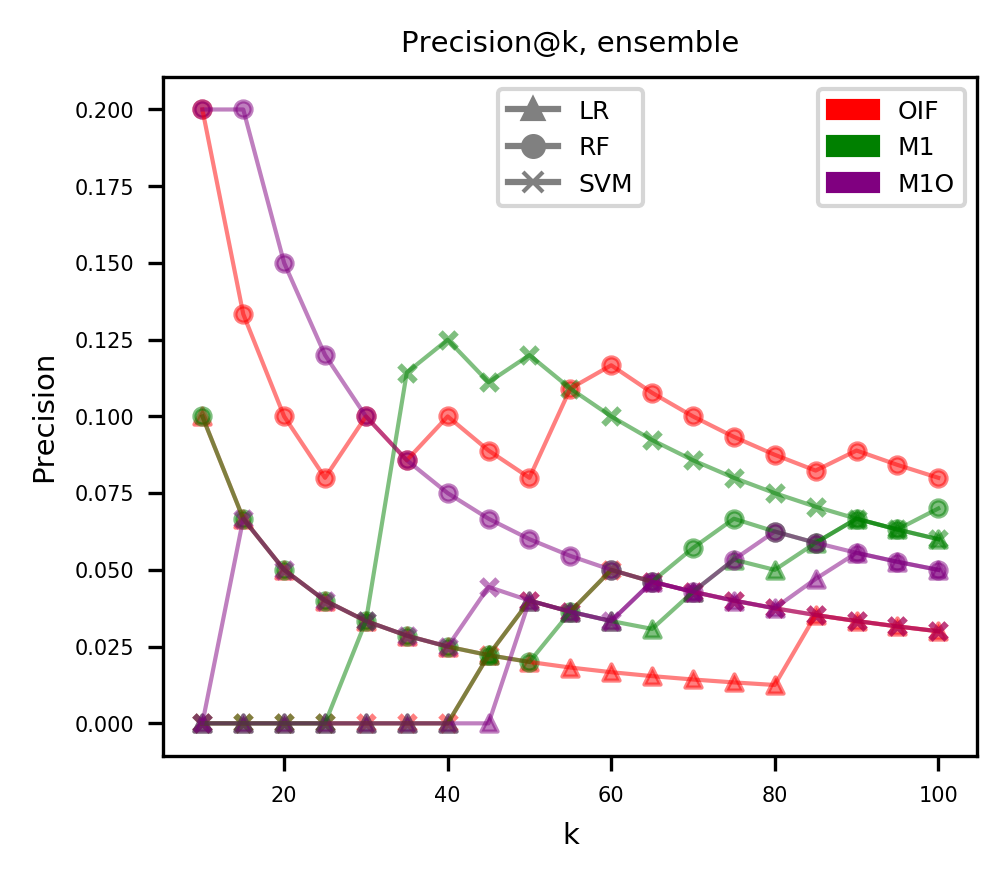

In [ ]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize = (3.5, 3), dpi = 300)
plt.rc('xtick', labelsize=5) 
plt.rc('ytick', labelsize=5) 
plt.xlabel('k', size=7)
plt.ylabel('Precision', size=7)
plt.title('Precision@k, ensemble', size=7)
plot_y = list(range(10,101,5))
model_names = ['LR', 'RF', "SVM"]
Set_names = ['OIF', 'M1', 'M1O']
marker_list = ['^', 'o', 'x']
color_list = ['red', 'green', 'purple']
x_list = [[precision_at_k_lr_set7,precision_at_k_rf_set7,precision_at_k_svm_set7],
          [precision_at_k_lr_set8,precision_at_k_rf_set8,precision_at_k_svm_set8],
          [precision_at_k_lr_set9,precision_at_k_rf_set9,precision_at_k_svm_set9]]
for i in range(3):
    for j in range(3):
        x = x_list[i][j]
        plt.scatter(plot_y,x,s=15, c=color_list[i], alpha=0.5, marker=marker_list[j],
            label='{}, {}'.format(Set_names[i], model_names[j]))
        plt.plot(plot_y,x, c=color_list[i], alpha=0.5, linewidth=1,
            label='{}, {}'.format(Set_names[i], model_names[j]))
patches = [mpatches.Patch(color=color_list[i], label=Set_names[i]) for i in range(3)]
first_legend = ax.legend(handles=patches, loc=1,prop={'size': 6})
ax.add_artist(first_legend)
lines = [mlines.Line2D([], [], color='gray', marker=marker_list[i],
                          markersize=5, label=model_names[i]) for i in range(3)]
ax.legend(handles=lines, loc=9,prop={'size': 6}) 
plt.show()

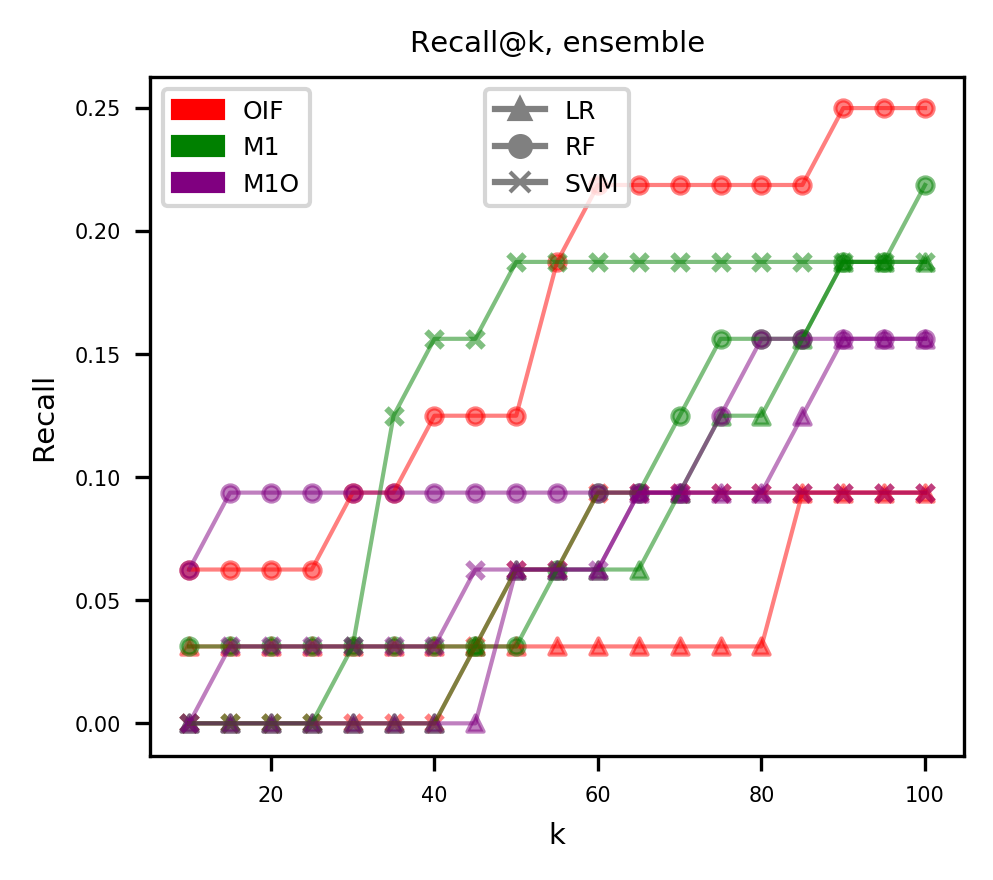

In [ ]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize = (3.5, 3), dpi = 300)
plt.rc('xtick', labelsize=5) 
plt.rc('ytick', labelsize=5) 
plt.title('Recall@k, ensemble', size=7)
plt.xlabel('k', size=7)
plt.ylabel('Recall', size=7)
plot_y = list(range(10,101,5))
model_names = ['LR', 'RF', "SVM"]
Set_names = ['OIF', 'M1', 'M1O']
marker_list = ['^', 'o', 'x']
color_list = ['red', 'green', 'purple']
x_list = [[recall_at_k_lr_set7,recall_at_k_rf_set7,recall_at_k_svm_set7],
          [recall_at_k_lr_set8,recall_at_k_rf_set8,recall_at_k_svm_set8],
          [recall_at_k_lr_set9,recall_at_k_rf_set9,recall_at_k_svm_set9]]
for i in range(3):
    for j in range(3):
        x = x_list[i][j]
        plt.scatter(plot_y,x,s=15, c=color_list[i], alpha=0.5, marker=marker_list[j],
            label='{}, {}'.format(Set_names[i], model_names[j]))
        plt.plot(plot_y,x, c=color_list[i], alpha=0.5, linewidth=1,
            label='{}, {}'.format(Set_names[i], model_names[j]))
patches = [mpatches.Patch(color=color_list[i], label=Set_names[i]) for i in range(3)]
first_legend = ax.legend(handles=patches, loc=2,prop={'size': 6})
ax.add_artist(first_legend)
lines = [mlines.Line2D([], [], color='gray', marker=marker_list[i],
                          markersize=5, label=model_names[i]) for i in range(3)]
ax.legend(handles=lines, loc=9,prop={'size': 6}) 
plt.show()

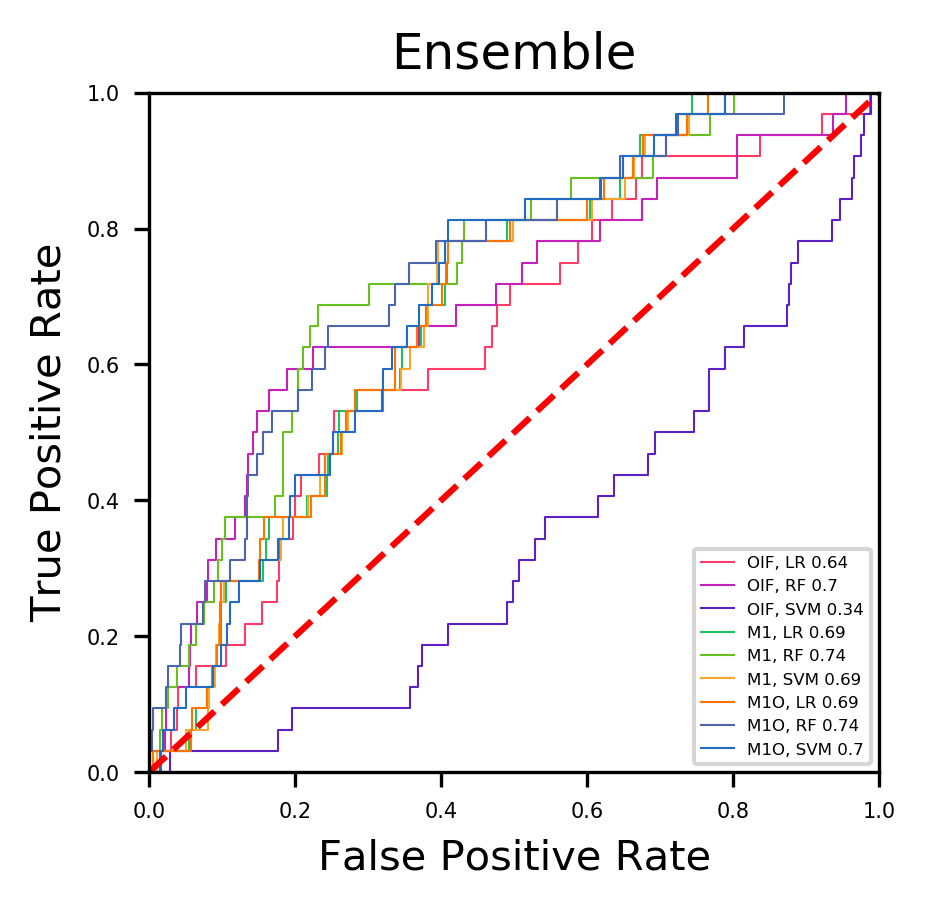

In [ ]:
import sklearn.metrics as metr
plt.figure(figsize = (3.14, 3), dpi = 300)
import matplotlib.colors as colors
colors_list = ['#FF3B68', '#C520B9', '#5E20C5',   '#1EC05F', '#68C01E', '#F9A729', 
               '#FF7400','#4D64AF', '#206CC5'] #,"#175A04",
plt.title('Ensemble')
j = 0
all_predictions = [[y_test_set7, y_pred_lr_test_proba_set7],
                   [y_test_set7, y_pred_rf_test_proba_set7],
                   [y_test_set7, y_pred_svm_test_proba_set7],
                   [y_test_set8, y_pred_lr_test_proba_set8],
                   [y_test_set8, y_pred_rf_test_proba_set8],
                   [y_test_set8, y_pred_svm_test_proba_set8],
                   [y_test_set9, y_pred_lr_test_proba_set9],
                   [y_test_set9, y_pred_rf_test_proba_set9],
                   [y_test_set9, y_pred_svm_test_proba_set9]]
labels = ['OIF, LR', 'OIF, RF', 'OIF, SVM',
         'M1, LR', 'M1, RF', 'M1, SVM',
         'M1O, LR', 'M1O, RF', 'M1O, SVM',]
for m in range(len(all_predictions)):
    fpr, tpr, threshold = metr.roc_curve(all_predictions[m][0],all_predictions[m][1])
    roc_auc = metr.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = labels[m]+ " "+str(round(roc_auc,2)), color = colors_list[m], 
            linewidth=0.5)
    j +=1
plt.legend(loc = 'lower right', prop={'size': 4})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#lt.savefig('ROCAUC_ensemble1.png', bbox_inches='tight')
plt.show()